

<font size = "5"> **pyTEMlib : [EELS_tools](../4_EELS_Tools.ipynb)** </font>

<hr style="height:1px;border-top:4px solid #FF8200" />



# Analysing Low-Loss Spectra with Drude Theory

[Download](https://raw.githubusercontent.com/pycroscopy/pyTEMlib/main/Spectroscopy/notebooks/EELS/Analyse_Low_Loss.ipynb)
 

rt of 

<font size = "4"> **pyTEMlib**, a **pycroscopy** library </font>


Notebook by 

Gerd Duscher

Microscopy Facilities
Materials Science & Engineering<br>
Institute of Advanced Materials & Manufacturing<br>
The University of Tennessee, Knoxville


Analyse EELS spectra and spectrum images.

## Content
The main feature in a low-loss EELS spectrum is the ``volume plasmon`` peak.

This ``volume plasmon`` and all other features in the ``low-loss`` region of an EELS spectrum are described by Dielectric Theory of Electrodynamics.

The simplest theory to interprete this energy range is the Drude theory. 

Another easy to observe component is the multiple scattering of this plasmon peak, which we can correct for or use for thickness determination.

>See [Notebook: Analysing Low-Loss Spectra with Drude Theory](https://raw.githubusercontent.com/gduscher/MSE672-Introduction-to-TEM/main/Spectroscopy/CH4_03-Drude.ipynb) of the MSE672-Introduction-to-TEM Lecture in my Github account.


## Load important packages

### Check Installed Packages


In [1]:
import sys
from pkg_resources import get_distribution, DistributionNotFound

def test_package(package_name):
    """Test if package exists and returns version or -1"""
    try:
        version = (get_distribution(package_name).version)
    except (DistributionNotFound, ImportError) as err:
        version = '-1'
    return version

# pyTEMlib setup ------------------
if test_package('pyTEMlib') < '0.2023.3.0':
    print('installing pyTEMlib')
    !{sys.executable} -m pip install  --upgrade pyTEMlib -q
# ------------------------------
print('done')

done


### Import all relevant libraries

Please note that the EELS_tools package from pyTEMlib is essential.

In [2]:
%matplotlib ipympl
import numpy as np
%gui qt5
import sys
sys.path.insert(0, '../../')

# additional package 
import ipywidgets as ipyw
from scipy.optimize import leastsq  ## fitting routine of scipy

# Import libraries from the book
import pyTEMlib
import pyTEMlib.file_tools as ft          # File input/ output library
from pyTEMlib import eels_tools  
import pyTEMlib.kinematic_scattering as ks         # Kinematic sCattering Library
                             # Atomic form factors from Kirklands book

# For archiving reasons it is a good idea to print the version numbers out at this point
print('pyTEM version: ',pyTEMlib.__version__)

Symmetry functions of spglib enabled
Using kinematic_scattering library version {_version_ }  by G.Duscher
pyTEM version:  0.2023.4.0


## Load and plot a spectrum

In [3]:
# Load file
filename = '../../example_data/AL-DFoffset0.00.dm3'

datasets=  ft.open_file(filename=filename)
chooser = ft.ChooseDataset(datasets)

Dropdown(description='select dataset:', options=('Channel_000: EELS90muOAonaxis3',), value='Channel_000: EELS9…

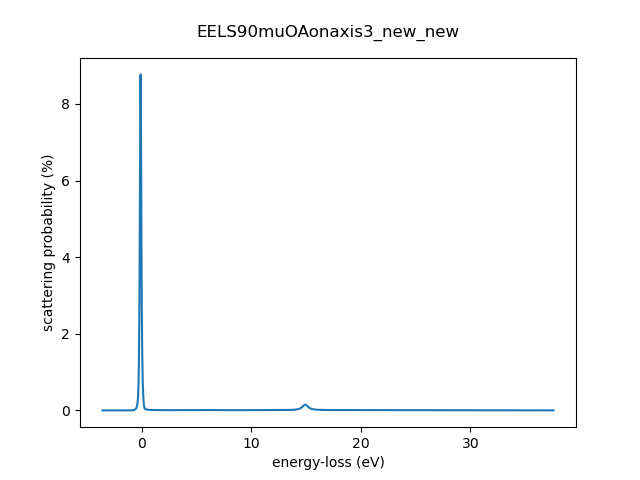

In [4]:
eels_dataset = chooser.dataset

if eels_dataset.data_type.name != 'SPECTRUM':
    print('We need an EELS spectrum for this notebook')

sum_spectrum = eels_dataset.sum()

eels_dataset = eels_dataset/sum_spectrum*100.
eels_dataset.units = '%'
eels_dataset.quantity = 'scattering probability'

view = eels_dataset.plot()

Here we do the follwing tasks:
### Fix energy scale and determine resolution function
> please see [Fitting the Zero-Loss Peak](./CH4_02-Fit_Zero_Loss.ipynb) for details

### Determine Relative Thickness 
The probabaility of an low-loss function in a solid angle is then:
$$\frac{\partial^2 P}{(\partial E \partial \Omega) }= t*  \frac{e}{\pi^2 a_0 m_0 v^2} {\rm Im} \left[ \frac{-1}{\varepsilon(q,E)} \right]
         \left( \frac{1}{\theta^2+\theta_E^2}\right)$$
         
>See [Notebook: Analysing Low-Loss Spectra with Drude Theory](https://raw.githubusercontent.com/gduscher/MSE672-Introduction-to-TEM/main/Spectroscopy/CH4_03-Drude.ipynb) of the MSE672-Introduction-to-TEM Lecture in my Github account.




Zero Loss with energy resolution of 0.18 eV at position -0.134 eV
energy_loss:  energy-loss (energy_loss) of size (2048,)
Sum of Zero-Loss: 84 counts
Sum of Spectrum: 100 counts
thickness [IMFP]: 0.17585


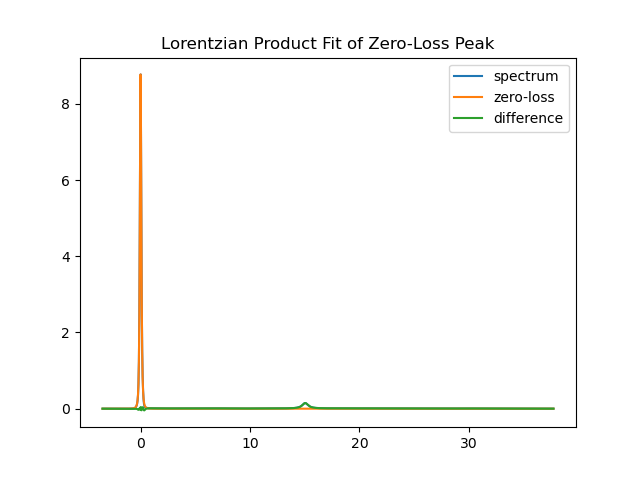

In [5]:
import matplotlib.pylab as plt
FWHM, energy_shift = eels_tools.fix_energy_scale(np.array(eels_dataset), eels_dataset.energy_loss)

print(f'Zero Loss with energy resolution of {FWHM:.2f} eV at position {energy_shift:.3f} eV')
eels_dataset.energy_loss -= energy_shift

zero_loss, _ = eels_tools.resolution_function(eels_dataset.energy_loss, eels_dataset, .4)
print(zero_loss)
plt.figure()
plt.plot(eels_dataset.energy_loss, eels_dataset, label='spectrum')
plt.plot(eels_dataset.energy_loss, zero_loss, label = 'zero-loss')
plt.plot(eels_dataset.energy_loss, np.array(eels_dataset)-zero_loss , label = 'difference')

plt.title ('Lorentzian Product Fit of Zero-Loss Peak')
#plt.xlim(-5,30)
plt.legend();
Izl = zero_loss.sum()
Itotal = np.array(eels_dataset).sum()
tmfp = np.log(Itotal/Izl)
print(f'Sum of Zero-Loss: {Izl:.0f} counts')
print(f'Sum of Spectrum: {Itotal:.0f} counts')
print (f'thickness [IMFP]: {tmfp:.5f}')



## Fitting a Drude Function to Plasmon

The position and the width are important materials parameters and we can derive them by fitting the Drude function to the volume plasmon region.
### Drude Function

Most of the inelastically scattered electron arise from interaction with outer shell electrons. These interactions, therefore, have a high intensity and are easy to obtain. 

The energy-loss function $F_{el}$ on the other hand is determined by the dielectric function $\varepsilon$ through:

$$
F_{el} = \Im \left[\frac{-1}{\varepsilon(\omega)} \right]
$$

The dielectric function in the Drude theory is given by two input parameters the position of the plasmon energy $E_p$
and the width of the plasmon $\Gamma$

$$ ε(ω) = ε1 + iε2 = 1 + χ = 1 − \frac{\omega_p^2}{\omega^2+\Gamma^2} + \frac{i\Gamma \omega_p^2}{\omega(\omega^2+\Gamma^2)}$$
Here $\omega$ is the angular frequency (rad/s) of forced oscillation and $\omega_p$ is the natural or resonance frequency for plasma oscillation, given by
$$ ω_p = \sqrt{\frac{ne^2}{(ε_0m_0)}} $$
A transmitted electron represents a sudden impulse of applied electric field, containing
all angular frequencies (Fourier components). Setting up a plasma oscillation of the loosely bound outer-shell electrons in a solid is equivalent to creating a pseudoparticle of energy $E_p = \hbar \omega_p$, known as a plasmon (Pines, 1963).

Drude Theory with Plamson Energy: 15.048552 eV and plasmon Width 0.72 eV
Max of Plasmon at 15.04 eV
Amplitude of  0.01 was deteremined by fit 


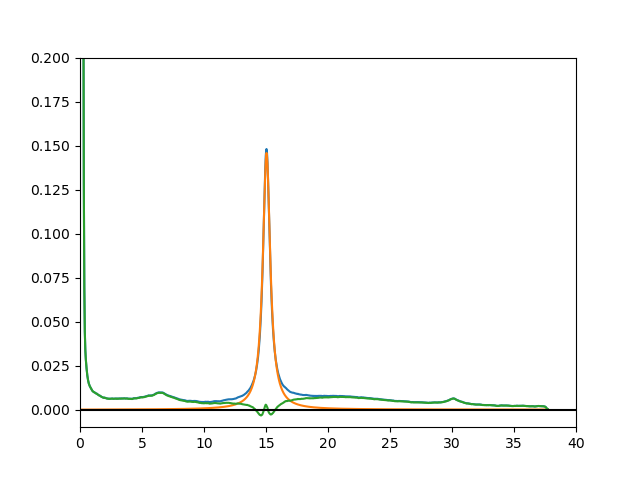

In [8]:
from scipy.optimize import leastsq

def Drude(E,Ep,Ew):
    eps = 1 - Ep**2/(E**2+Ew**2) +1j* Ew* Ep**2/E/(E**2+Ew**2)
    elf = (-1/eps).imag
    return eps,elf

def errfDrude(p, y, x):
    eps,elf = Drude(x,p[0],p[1])
    err = y - p[2]*elf
    #print (p,sum(np.abs(err)))
    return np.abs(err)#/np.sqrt(y)


pin2 = np.array([15,1,.7])
E = energy_scale
startFit =np.argmin(abs(energy_scale-13))
endFit = np.argmin(abs(energy_scale-18))
    
p2, lsq = leastsq(errfDrude, pin2, args=(eels_dataset[startFit:endFit], energy_scale[startFit:endFit]), maxfev=2000)

eps, elf =Drude(energy_scale,p2[0],p2[1])
drudePSD = p2[2]* elf
plt.figure()

plt.plot(energy_scale,eels_dataset)
plt.plot(energy_scale,drudePSD)
plt.plot(energy_scale,eels_dataset-drudePSD)
plt.axhline(0, color='black')

plt.gca().set_xlim(0,40)
plt.gca().set_ylim(-0.01,0.2)
print(f"Drude Theory with Plamson Energy: {p2[0]:2f} eV and plasmon Width {p2[1]:.2f} eV") 
print(f"Max of Plasmon at {energy_scale[drudePSD.argmax(0)]:.2f} eV")
print(f"Amplitude of  {p2[2]:.2f} was deteremined by fit ")


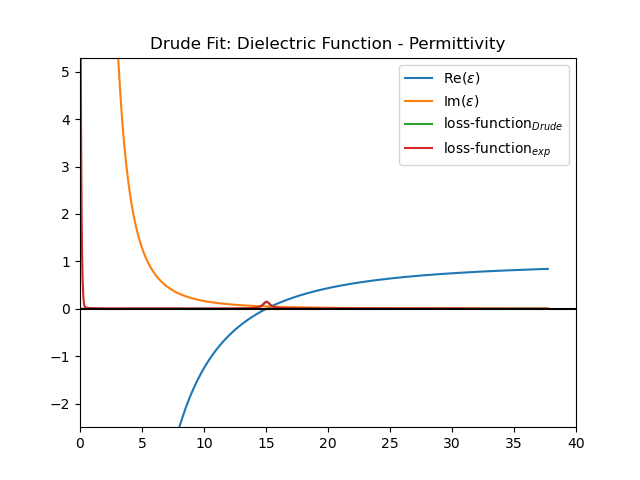

In [9]:
plt.figure()
plt.title ('Drude Fit: Dielectric Function - Permittivity')
plt.plot(energy_scale,eps.real,label = 'Re($\epsilon)$')
plt.plot(energy_scale,eps.imag,label = 'Im($\epsilon)$')
plt.plot(energy_scale,drudePSD,label = 'loss-function$_{Drude}$')
plt.plot(energy_scale,eels_dataset,label = 'loss-function$_{exp}$')
plt.axhline(0, color='black')

plt.gca().set_xlim(0,40)
plt.gca().set_ylim(-2.5,5.3)

plt.legend();

## Summary

The beauty of ``Low--Loss spectroscopy`` is its derivation of the dielectric function to high energies without prior knowledge of the composition. The signal is strong and the acquisition time is mostly restricted by the dynamic range of the spectrum.


**Think of low-loss spectroscopy as Electrodynamics**

The advantages of EELS is the derivation of these values spatially resolved.
And from a linescan across an Si/SiO$_2$ interface the dielectric function per pixel can be obtained. From that we can calculate the dielectric polarizability $\alpha_e (E)$, which may be  a measure of the dielectric strength.


We obtain more or less easily:
- relative thickness
- absolute thickness 
- inelastic mean free path
- plasmon frequency
- plasmon width
- band gap
- dielectric function
- reflectivity 
- absorption
- effective number of electrons per atoms 
 


The analysis of the optical data requires the exact knowledge of the zero-loss peak. Because of the weighting in the Fourier Analysis, the low energy part contributes heavily to the dielectric function. Therefore, energy resolution is critical for an exact determination of all the optical values from EELS. The new monochromated TEMs are now able to achieve an energy resolution of 10 meV (one is at the oak Ridge National Laboratory), which allows for a sharper zero-loss peak. Such a sharp zero-loss peak will enable us to extract this low energy data more accurately. The dielectric function and the parameters derived from it, can be more precisely determined from such EELS spectra.


## Navigation
- <font size = "3">  **Up Chapter 4: [Imaging](CH4_00-Spectroscopy.ipynb)** </font>
- <font size = "3">  **Back: [Zero-Loss](CH4_02-Fit_Zero_Loss.ipynb)** </font>
- <font size = "3">  **Next: [Introduction to Core-Loss](./CH4_07-Introduction_Core_Loss.ipynb)** </font>
- <font size = "3">  **List of Content: [Front](../_MSE672_Intro_TEM.ipynb)** </font>